<a href="https://colab.research.google.com/github/DurbaChakraborty1021/Machine-Learning-for-Healthcare/blob/main/med_im_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics medmnist torch-fidelity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 135.5 MB/s eta 0:00:00


In [ ]:
# Importing Lightning modules for model training and management
import lightning as L
from lightning.pytorch import Trainer, seed_everything  # Trainer handles the training loop; seed_everything ensures reproducibility
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger  # Loggers are used for tracking training progress and metrics
from lightning.pytorch.callbacks.early_stopping import EarlyStopping  # Stops training early if performance doesn't improve
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint  # Monitors the learning rate and saves the best model during training

# Metrics for evaluating generative models using Frechet Inception Distance (FID) and Kernel Inception Distance (KID)
from torchmetrics.image.fid import FrechetInceptionDistance  # Evaluates quality of generated images compared to real ones
from torchmetrics.image.kid import KernelInceptionDistance  # Similar to FID but more robust for smaller datasets

# Enables showing images in Google Colab
from google.colab.patches import cv2_imshow

# Importing PyTorch and related modules for deep learning
import torch  # Main PyTorch library
import torch.nn as nn  # For building neural network layers
import torch.optim as optim  # For defining optimization algorithms
import torch.utils.data as data  # Utilities for handling datasets and data loaders
import torch.nn.functional as F  # Contains various functions used for operations in the forward pass

# Importing torchvision for transformations and image preprocessing
import torchvision.transforms as transforms  # Provides standard data augmentation and preprocessing techniques
from torchvision.transforms import (
    Compose,  # Chains multiple transformations together
    ToTensor,  # Converts images to PyTorch tensors
    Lambda,  # Allows custom transformations
    ToPILImage,  # Converts tensors back to PIL images
    Resize  # Resizes images to a specific size
)

# PIL for image processing
from PIL import Image  # Provides image opening, editing, and saving capabilities

# Libraries for numerical operations and visualization
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For visualizing data and training progress

# MedMNIST library for medical image datasets and utilities
from medmnist.dataset import MedMNIST  # Provides medical image datasets
from medmnist.info import INFO  # Contains dataset information
from medmnist.utils import montage2d  # Creates a montage of images for visualization

# Additional standard libraries
import os  # For file and directory operations
import cv2  # For image processing tasks like reading, writing, and transformations
import random  # For generating random numbers
import math  # For mathematical functions

# Suppresses warnings to declutter output
import warnings
warnings.filterwarnings("ignore")

# Setting up inline plotting for Jupyter/Colab and customizing plot appearance
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'  # Changes background color of plots
plt.rcParams['mathtext.fontset'] = 'cm'  # Uses Computer Modern font for mathematical text
plt.rcParams['font.family'] = 'STIXGeneral'  # Sets font family for consistency


In [ ]:
MAX_EPOCH = 60
# The maximum number of epochs for training.
# An epoch means a full pass through the entire training dataset.
# Set to 60 to allow sufficient training iterations.

BATCH_SIZE = 200
# The number of samples processed in one forward and backward pass.
# A batch size of 200 ensures faster training while keeping memory usage reasonable.

LR = 4.3e-02
# Learning rate for the optimizer, set to 0.043.
# This determines how much to adjust the weights of the model during training.
# A moderate value is chosen to balance convergence speed and stability.

CHECKPOINT_DIR = os.getcwd()
# The directory where model checkpoints (saved versions of the model) will be stored.
# `os.getcwd()` sets it to the current working directory.

FLAG = "bloodmnist"
# The specific dataset being used from MedMNIST.
# `bloodmnist` is a medical image dataset related to blood sample classification.

IMAGE_SIZE = 32
# The size to which input images are resized (32x32 pixels).
# This is common for image datasets to ensure consistent input dimensions.

N_CHANNEL = INFO[FLAG]['n_channels']
# The number of color channels in the images (e.g., 1 for grayscale, 3 for RGB).
# Retrieved from the MedMNIST dataset information dictionary using the `FLAG` key.


In [ ]:
# Generate a random seed for reproducibility in dataset preparation or training
DATA_SEED = int(np.random.randint(2147483647))  # Generates a random integer  between 0 and 2147483647 and assigns it to DATA_SEED.
print(f"Random seed: {DATA_SEED}")  # Outputs the seed value for tracking and potential reuse


Random seed: 262695101


**Why it's important for reproducibility:**

Imagine you're training a machine learning model. If you use random numbers without setting a seed, the results will be slightly different each time you train the model. This makes it difficult to compare results and ensure that your model is actually improving. By using a seed, you ensure that the random aspects of your code (e.g., shuffling data, initializing model weights) are consistent, leading to reproducible results.

I hope this explanation clarifies the concept of a random seed and its role in reproducibility within your code. Let me know if you have any further questions.

In [ ]:
# Define a transformation pipeline for preprocessing images
image_transform = Compose(
    [
        Resize(IMAGE_SIZE),  # Resizes the image to a fixed size (e.g., 32x32 pixels) to ensure consistency across the dataset
        ToTensor(),  # Converts the image to a PyTorch tensor and scales pixel values to the range [0, 1]
        Lambda(lambda x: (x * 2) - 1),  # Custom transformation: scales the pixel values from [0, 1] to [-1, 1]
    ]
)


In [ ]:
# Custom class inheriting from MedMNIST to implement additional functionality for 2D medical image datasets
class MedMNIST2D(MedMNIST):

    # Prunes the dataset to make it compatible with the batch size and updates dataset info
    @property
    def __prune__(self):
        random.seed(DATA_SEED)  # Ensures reproducibility by using the fixed random seed
        random.shuffle(self.imgs)  # Shuffles the images for randomness in data distribution

        prune_idx = len(self.imgs) - (len(self.imgs) % BATCH_SIZE)  # Calculates the largest divisible subset of images
        if self.split == "train":
            self.imgs = self.imgs[:prune_idx]  # Trims the training dataset
            self.info["n_samples"][self.split] = prune_idx  # Updates sample count after pruning
        elif self.split == "test":
            self.imgs = self.imgs[:prune_idx]  # Trims the testing dataset
            self.info["n_samples"][self.split] = prune_idx  # Updates sample count
        elif self.split == "val":
            self.imgs = self.imgs[:prune_idx]  # Trims the validation dataset
            self.info["n_samples"][self.split] = prune_idx  # Updates sample count
        else:
            raise ValueError  # Raises an error if the split is not recognized

    # Retrieves an image from the dataset and applies transformations if specified
    def __getitem__(self, index):
        """
        Returns:
            img: A single image (with or without transformation).
        """
        img = self.imgs[index]  # Retrieves the image at the specified index
        img = Image.fromarray(img)  # Converts the NumPy array to a PIL image

        if self.as_rgb:  # Converts the image to RGB if specified
            img = img.convert("RGB")

        if self.transform is not None:  # Applies specified transformations to the image
            img = self.transform(img)

        return img

    # Creates a montage of images for visualization
    def montage(self, length=20, replace=False, save_folder=None):
        n_sel = length * length  # Determines the total number of images in the montage
        sel = np.random.choice(self.__len__(), size=n_sel, replace=replace)  # Randomly selects images

        montage_img = montage2d(
            imgs=self.imgs,  # Images to include in the montage
            n_channels=self.info["n_channels"],  # Number of image channels (e.g., RGB or grayscale)
            sel=sel  # Indices of selected images
        )

        if save_folder is not None:  # Saves the montage to a folder if specified
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)  # Creates the folder if it doesn't exist
            montage_img.save(
                os.path.join(save_folder, f"{self.flag}_{self.split}_montage.jpg")  # Saves the montage as a .jpg file
            )

        return montage_img  # Returns the montage image for further use

# Custom dataset class inheriting from MedMNIST2D with a predefined flag for the dataset
class BiomedicalDataset(MedMNIST2D):
    flag = FLAG  # Sets the dataset flag, such as "bloodmnist" in this case


In [ ]:
# Create the training dataset using the custom BiomedicalDataset class
TrainDataset = BiomedicalDataset(
    split="train",            # Specifies that this dataset contains training data
    transform=image_transform,  # Applies the defined image transformations (resize, to tensor, etc.)
    download=True,            # Downloads the dataset if it is not already available locally
)

# Create the testing dataset using the custom BiomedicalDataset class
TestDataset = BiomedicalDataset(
    split="test",             # Specifies that this dataset contains testing data
    transform=image_transform,  # Applies the same transformations to maintain consistency
    download=True,            # Ensures the test dataset is downloaded
)

# Create the validation dataset using the custom BiomedicalDataset class
ValDataset = BiomedicalDataset(
    split="val",              # Specifies that this dataset contains validation data
    transform=image_transform,  # Applies the defined transformations
    # `download` is omitted as validation data is typically included with training data
)


100%|██████████| 35.5M/35.5M [00:03<00:00, 10.4MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [ ]:
# Prune the training dataset to ensure the number of samples is divisible by the batch size
TrainDataset.__prune__

# Prune the testing dataset to ensure consistent batch sizes during evaluation
TestDataset.__prune__

# Prune the validation dataset to ensure uniformity across validation batches
ValDataset.__prune__


In [ ]:
INFO[FLAG]['description']

'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.'

3: Represents the number of color channels (likely RGB, where 3 stands for Red, Green, and Blue).
360: Represents the height of the images in pixels.
363: Represents the width of the images in pixels.

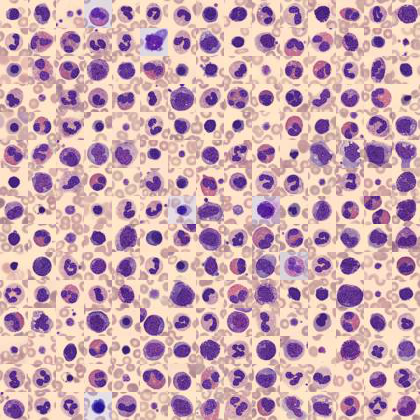

In [ ]:
# Generate a montage of 15x15 images from the training dataset for visualization
TrainDataset.montage(15)


The argument 15 likely determines the dimensions of the montage grid. In this case, it's creating a 15x15 grid, which means it will display 225 images.

In [ ]:
def get_index_from_list(vals, t, x_shape):
    """
    Retrieves specific indices from a list of values, considering batch dimensions.

    Args:
        vals: Tensor of values from which indices are selected.
        t: Tensor of indices, typically batch-sized, used to select values from `vals`.
        x_shape: Shape of the input tensor, used to reshape the output appropriately.

    Returns:
        A tensor containing the selected values with the same device as `t` and reshaped
        to be compatible with the batch dimension.
    """
    # Get the batch size from the shape of `t`
    batch_size = t.shape[0]

    # Use the `gather` method to fetch the values at indices specified by `t`
    # `t.cpu()` ensures indices are on the CPU (required for certain operations)
    out = vals.gather(-1, t.cpu())

    # Reshape the output tensor to match the batch size and extend dimensions
    # to be compatible with the rest of the input shape `x_shape`
    out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

    # Move the reshaped tensor back to the same device as `t` (e.g., GPU or CPU)
    return out.to(t.device)


In [ ]:
class AvgMeter(object):
    """
    A helper class for tracking and computing the running average of values over a defined window.
    Typically used for monitoring metrics like loss or accuracy during training.
    """

    def __init__(self, num=40):
        """
        Initializes the AvgMeter instance with a sliding window size.

        Args:
            num (int): The maximum number of recent values to consider for averaging.
        """
        self.num = num  # Set the size of the sliding window
        self.reset()    # Initialize the scores list

    def reset(self):
        """
        Resets the tracked scores.
        This is useful when starting a new session or epoch.
        """
        self.scores = []  # Clear the list of stored scores

    def update(self, val):
        """
        Adds a new value to the scores list.

        Args:
            val (float or Tensor): The new metric value to track.
        """
        self.scores.append(val)  # Store the new value in the list

    def show(self):
        """
        Computes and returns the average of the most recent `num` values.

        Returns:
            Tensor: The average of the values within the sliding window.
        """
        # Determine the range of scores to include based on the sliding window
        recent_scores = self.scores[np.maximum(len(self.scores) - self.num, 0):]

        # Convert the recent scores into a PyTorch tensor and calculate the mean
        out = torch.mean(torch.stack(recent_scores))

        return out  # Return the calculated average


**Noise Scheduler**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NoiseScheduler(nn.Module):
    """
    A class for implementing a noise scheduler used in diffusion models.
    This scheduler adds noise to data (e.g., images) progressively over time steps.
    """

    def __init__(self, T=500):
        """
        Initializes the noise scheduler.

        Args:
            T (int): Total number of timesteps for the diffusion process.
        """
        super().__init__()
        self.T = T  # Total number of timesteps

        # Create a linearly spaced sequence of beta values for the diffusion process
        self.betas = torch.linspace(1e-04, 2e-02, self.T)  # Noise schedule

        # Compute alphas and their cumulative products
        alphas = 1.0 - self.betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)  # Cumulative product of alphas
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # Previous alphas_cumprod with padding

        # Precompute values for the forward diffusion process
        self.sqrt_recip_alphas = torch.sqrt(1.0 / alphas)  # Square root of reciprocal alphas
        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)  # Square root of cumulative product of alphas
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)  # Square root of one minus cumulative product of alphas

        # Variance for the posterior distribution during the reverse diffusion process
        self.posterior_variance = (
            self.betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )

    def forward(self, x, t):
        """
        Runs the forward diffusion process for a given input and timestep.

        Args:
            x (Tensor): The input data (e.g., an image).
            t (Tensor): The timestep index.

        Returns:
            Tuple[Tensor, Tensor]: Noisy version of the input and the noise added.
        """
        return self._forward_diffusion_sample(x, t)

    def _forward_diffusion_sample(self, x_0, t):
        """
        Adds noise to the input data based on the current timestep.

        Args:
            x_0 (Tensor): The original input data (e.g., an image).
            t (Tensor): The timestep index.

        Returns:
            Tuple[Tensor, Tensor]:
                - Noisy version of the input (x_t).
                - The noise added to generate the noisy version.
        """
        device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Generate random noise with the same shape as the input
        noise = torch.randn_like(x_0)

        # Retrieve the precomputed alpha values for the given timestep
        sqrt_alphas_cumprod_t = get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)

        # Combine input data and noise to generate the noisy sample
        noisy_sample = sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + \
                       sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return noisy_sample, noise.to(device)  # Return the noisy data and the added noise


In [ ]:
FORWARD = NoiseScheduler

**U-Net**

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the number of input channels for the images (e.g., RGB images have 3 channels)
N_CHANNEL = 3


# A building block for the U-Net architecture
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        """
        Initialize the block.
        Args:
            in_ch: Number of input channels.
            out_ch: Number of output channels.
            time_emb_dim: Dimension of the time embedding vector.
            up: If True, perform upsampling; otherwise, perform downsampling.
        """
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            # Transpose convolution for upsampling
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            # Standard convolution for downsampling
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        # Additional convolutions and batch normalizations
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        """
        Forward pass through the block.
        Args:
            x: Input tensor.
            t: Time embedding tensor.
        Returns:
            Transformed tensor.
        """
        # First convolution followed by batch normalization and activation
        h = self.bnorm1(self.relu(self.conv1(x)))

        # Add time-dependent information
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]  # Expand dimensions
        h = h + time_emb

        # Second convolution followed by batch normalization and activation
        h = self.bnorm2(self.relu(self.conv2(h)))

        # Perform upsampling or downsampling
        return self.transform(h)


# Encodes temporal information as positional embeddings
class PositionalEmbedding(nn.Module):
    def __init__(self, dim):
        """
        Initialize the positional embedding module.
        Args:
            dim: Dimension of the embeddings.
        """
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Compute positional embeddings for a given time step.
        Args:
            time: Tensor of time steps.
        Returns:
            Positional embeddings.
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


# The U-Net architecture for image-to-image tasks
class UNet(nn.Module):
    def __init__(self, image_channels=N_CHANNEL, scale=4):
        """
        Initialize the U-Net model.
        Args:
            image_channels: Number of input image channels.
            scale: Downscaling factor for channels to control model size.
        """
        super().__init__()

        # Define the number of channels for downsampling and upsampling stages
        down_channels = (
            64 // scale,
            128 // scale,
            256 // scale,
            512 // scale,
            1024 // scale,
        )
        up_channels = (
            1024 // scale,
            512 // scale,
            256 // scale,
            128 // scale,
            64 // scale,
        )
        out_dim = 3  # Output image channels
        time_emb_dim = 32  # Time embedding dimension

        # Define time embedding layers
        self.time_mlp = nn.Sequential(
            PositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )

        # Initial projection layer
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsampling layers
        self.downs = nn.ModuleList(
            [
                Block(down_channels[i], down_channels[i + 1], time_emb_dim)
                for i in range(len(down_channels) - 1)
            ]
        )

        # Upsampling layers
        self.ups = nn.ModuleList(
            [
                Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True)
                for i in range(len(up_channels) - 1)
            ]
        )

        # Final output layer to map to desired output channels
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        """
        Forward pass through the U-Net model.
        Args:
            x: Input image tensor.
            timestep: Time step tensor for diffusion models.
        Returns:
            Processed image tensor.
        """
        # Embed the time step
        t = self.time_mlp(timestep)

        # Initial convolution
        x = self.conv0(x)

        # Downsampling with residual storage
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        # Upsampling with residual connections
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)  # Add residual channels
            x = up(x, t)

        # Final output layer
        return self.output(x)


In [ ]:
BACKWARD = UNet

## **Wrapper**

This code represents a PyTorch Lightning-based class for training a diffusion model, which is used in generative tasks such as image generation or denoising. Below is a high-level overview of the algorithmic process, step-by-step:

### 1. **Model Initialization (`__init__`)**:
   - The model is initialized with a **forward model** (which adds noise) and a **backward model** (which denoises the noisy images).
   - Parameters like **batch size**, **learning rate**, and **maximum epochs** are also initialized.
   - The model loss and evaluation metrics are prepared for tracking.
   - It configures the device (`cuda` if available) and initializes essential metrics like **FID** (Frechet Inception Distance) and **KID** (Kernel Inception Distance).

### 2. **Forward Pass (`forward`)**:
   - In **training mode**, the model:
     - Adds noise to the input image using the **forward model**.
     - Predicts the noise in the noisy image using the **backward model**.
     - Computes the **L1 loss** between the predicted noise and actual noise.
   - In **inference mode**, the model uses the **backward model** to denoise the input image.

### 3. **Training Steps**:
   - **Start of each epoch**: The **FID** and **KID** metrics are reset.
   - For each **training batch**:
     - A random timestep `t` is sampled.
     - The loss is computed by passing the batch through the model.
     - The model's gradients are calculated manually, and the optimizer updates the parameters.
     - The loss is logged and recorded.
   - **End of each epoch**:
     - The learning rate scheduler is updated.
     - The epoch's model loss is logged for tracking.
   
### 4. **Validation Steps**:
   - **Start of each validation epoch**: The **FID** and **KID** metrics are reset.
   - For each **validation batch**:
     - FID and KID metrics are updated with real images.
     - A reverse diffusion process is performed:
       - Starting from random noise, the model iteratively generates the image by denoising over multiple timesteps.
     - FID and KID metrics are updated with generated (fake) images.
   - **End of each validation epoch**:
     - The **FID**, **mean KID**, and **standard deviation KID** for the current epoch are logged.

### 5. **Testing Steps**:
   - **For each test batch**:
     - Similar to validation, the model generates an image using the reverse diffusion process.
     - FID and KID metrics are updated with generated images.
   - **End of the testing phase**:
     - FID and KID scores are logged for final evaluation.

### 6. **Training and Evaluation Plots**:
   - **End of training**: The loss, FID, and KID curves are plotted and saved as images. These are used for visualization of the training and evaluation process over time.

### 7. **Data Loading**:
   - **Training**, **validation**, and **testing** datasets are loaded using separate **DataLoaders** for each phase.

### 8. **Optimizer Configuration**:
   - The optimizer (SGD with momentum) and a **custom learning rate scheduler** are configured.
   - The learning rate scheduler decreases the learning rate at specific milestones using a gamma computed from mathematical constants.

### Key Concepts:
- **Diffusion Process**: A process where noise is progressively added to the image (forward diffusion) and then reversed (backward diffusion) to generate or denoise the image.
- **FID and KID**: Metrics used to evaluate the quality of generated images. FID compares the distribution of real and generated features, while KID computes a statistical distance based on the Inception feature space.

### Summary of the Algorithm:
1. **Training Phase**:
   - Noise is added to images, and noise is predicted and used for loss calculation.
   - Optimizer updates the model based on gradients.

2. **Validation/Testing Phase**:
   - The model generates images via reverse diffusion and compares them using FID and KID metrics.

3. **Evaluation**:
   - At the end of each epoch, the metrics (FID, KID) are logged and visualized.

4. **Final Step**:
   - Evaluation metrics are plotted at the end of training and testing to track the model's performance over time.

This framework allows for the training of diffusion models, specifically designed for image generation or denoising tasks, with a structured approach to optimization, evaluation, and visualization.

In [ ]:
class DiffusionModel(L.LightningModule):
    def __init__(
        self,
        forward_model,  # Forward model to add noise (e.g., noise schedule)
        backward_model,  # Backward model to denoise the noisy images
        batch_size,  # Batch size for training
        lr,  # Learning rate
        max_epoch,  # Maximum number of epochs
    ):
        super().__init__()

        # Initialize models and parameters
        self.forward_model = forward_model
        self.backward_model = backward_model

        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        # Disable automatic optimization for manual backward pass
        self.automatic_optimization = False

        # Track model loss and evaluation metrics
        self.model_loss = []
        self.val_fid = []
        self.val_mean_kid = []
        self.val_std_kid = []

        # Initialize tracking meters for performance
        self.model_loss_recorder = AvgMeter()
        self.val_fid_recorder = AvgMeter()
        self.val_mean_kid_recorder = AvgMeter()
        self.val_std_kid_recorder = AvgMeter()

        # Set device to GPU if available, else CPU
        self._device = "cuda" if torch.cuda.is_available() else "cpu"
        self._T = self.forward_model.T  # Number of timesteps in diffusion process

        # Initialize metrics for FID and KID calculation
        self.fid = FrechetInceptionDistance(feature=64, normalize=True)
        self.kid = KernelInceptionDistance(
            feature=64,
            subset_size=50,
            normalize=True,
        )

    def forward(self, x, t):
        """
        Forward pass of the model.
        During training, it predicts the noise from the noisy image.
        During inference, it generates denoised images.
        """
        if self.training:
            x_noisy, noise = self.forward_model(x, t)  # Add noise to images
            noise_pred = self.backward_model(x_noisy, t)  # Predict the noise
            return F.l1_loss(noise, noise_pred)  # L1 loss between predicted and true noise
        else:
            return self.backward_model(x, t)  # Return denoised image during inference

    def on_train_epoch_start(self):
        """Reset FID and KID metrics at the start of each training epoch."""
        self.fid.reset()
        self.kid.reset()

    def training_step(self, batch, batch_nb):
        """Training step for each batch."""
        x = batch
        # Update FID and KID with real images
        self.fid.update((x + 1.0) / 2.0, real=True)
        self.kid.update((x + 1.0) / 2.0, real=True)

        # Sample random timesteps
        t = torch.randint(0, self._T, (self.batch_size,), device=self._device).long()

        # Compute loss
        loss = self(x, t)

        # Get optimizer and perform backward pass
        opt = self.optimizers()
        opt.zero_grad()  # Zero gradients
        self.manual_backward(loss)  # Manually compute gradients
        opt.step()  # Update parameters

        # Log model loss and update loss recorder
        self.log("model_loss", loss, prog_bar=True)
        self.model_loss_recorder.update(loss.data)

    def on_train_epoch_end(self):
        """End of training epoch: update learning rate scheduler and log loss."""
        sch = self.lr_schedulers()
        sch.step()  # Update learning rate scheduler

        # Record the model loss for the current epoch
        self.model_loss.append(self.model_loss_recorder.show().data.cpu().numpy())
        self.model_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        """Validation step for each batch."""
        x = batch
        # Update FID and KID with real images for validation
        self.fid.update((x + 1.0) / 2.0, real=True)
        self.kid.update((x + 1.0) / 2.0, real=True)

        # Generate noisy image to test reverse diffusion process
        _x = torch.randn(x.shape, device=self._device)
        for _t in range(0, self._T)[::-1]:  # Reverse diffusion process
            t = torch.full((x.shape[0],), _t, device=self._device, dtype=torch.long)

            # Get parameters for the current timestep
            betas_t = get_index_from_list(self.forward_model.betas, t, _x.shape)
            sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
                self.forward_model.sqrt_one_minus_alphas_cumprod, t, _x.shape
            )
            sqrt_recip_alphas_t = get_index_from_list(
                self.forward_model.sqrt_recip_alphas, t, _x.shape
            )

            # Calculate model mean for reverse diffusion
            model_mean = sqrt_recip_alphas_t * (
                _x - betas_t * self(_x, t) / sqrt_one_minus_alphas_cumprod_t
            )

            # Get posterior variance for the current timestep
            posterior_variance_t = get_index_from_list(
                self.forward_model.posterior_variance, t, _x.shape
            )

            # Update the noisy image based on the model's prediction
            if torch.sum(t) == 0:
                _x = model_mean
            else:
                noise = torch.randn_like(_x)
                _x = model_mean + torch.sqrt(posterior_variance_t) * noise.to(self._device)
            _x = torch.clamp(_x, -1.0, 1.0)  # Clamp the generated image within valid range

        # Update FID and KID with generated (fake) images
        self.fid.update((_x + 1.0) / 2.0, real=False)
        self.kid.update((_x + 1.0) / 2.0, real=False)

        # Log FID and KID scores
        fid = self.fid.compute().data.cpu()
        self.log("val_fid", fid, prog_bar=True)
        self.val_fid_recorder.update(fid)

        mu_kid, std_kid = self.kid.compute()
        self.log("val_mean_kid", mu_kid.data.cpu(), prog_bar=True)
        self.log("val_std_kid", std_kid.data.cpu(), prog_bar=True)
        self.val_mean_kid_recorder.update(mu_kid.data.cpu())
        self.val_std_kid_recorder.update(std_kid.data.cpu())

    def on_validation_epoch_end(self):
        """End of validation epoch: log and record evaluation metrics."""
        # Record FID, KID mean, and KID std for each epoch
        self.val_fid.append(self.val_fid_recorder.show().data.cpu().numpy())
        self.val_fid_recorder = AvgMeter()

        self.val_mean_kid.append(self.val_mean_kid_recorder.show().data.cpu().numpy())
        self.val_mean_kid_recorder = AvgMeter()

        self.val_std_kid.append(self.val_std_kid_recorder.show().data.cpu().numpy())
        self.val_std_kid_recorder = AvgMeter()

    def test_step(self, batch, batch_nb):
        """Test step to evaluate the model performance."""
        x = batch
        # Update FID and KID with real images for testing
        self.fid.update((x + 1.0) / 2.0, real=True)
        self.kid.update((x + 1.0) / 2.0, real=True)

        # Generate images from random noise and compute FID/KID
        _x = torch.randn(x.shape, device=self._device)
        for _t in range(0, self._T)[::-1]:
            t = torch.full((x.shape[0],), _t, device=self._device, dtype=torch.long)
            betas_t = get_index_from_list(self.forward_model.betas, t, _x.shape)
            sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
                self.forward_model.sqrt_one_minus_alphas_cumprod, t, _x.shape
            )
            sqrt_recip_alphas_t = get_index_from_list(
                self.forward_model.sqrt_recip_alphas, t, _x.shape
            )
            model_mean = sqrt_recip_alphas_t * (
                _x - betas_t * self(_x, t) / sqrt_one_minus_alphas_cumprod_t
            )
            posterior_variance_t = get_index_from_list(
                self.forward_model.posterior_variance, t, _x.shape
            )
            if torch.sum(t) == 0:
                _x = model_mean
            else:
                noise = torch.randn_like(_x)
                _x = model_mean + torch.sqrt(posterior_variance_t) * noise.to(self._device)
            _x = torch.clamp(_x, -1.0, 1.0)
        # Update FID and KID with generated images
        self.fid.update((_x + 1.0) / 2.0, real=False)
        self.kid.update((_x + 1.0) / 2.0, real=False)

    def on_test_epoch_end(self):
        """Log final evaluation metrics at the end of testing."""
        fid = self.fid.compute().data.cpu()
        self.log("test_fid", fid, prog_bar=False, logger=True)

        mu_kid, std_kid = self.kid.compute()
        self.log("mu_kid", mu_kid.data.cpu(), prog_bar=False, logger=True)
        self.log("std_kid", std_kid.data.cpu(), prog_bar=False, logger=True)

    def on_train_end(self):
        """Plot and display the loss and evaluation metrics at the end of training."""
        # Plot and save loss curve
        loss_img_file = f"/content/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.model_loss, color="r")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Plot and save FID curve
        evaluation_metric_img_file = f"/content/{MODEL_NAME}_fid_plot.png"
        plt.plot(self.val_fid[1:], color="b")
        plt.title("FID Curves")
        plt.xlabel("Epoch")
        plt.ylabel("FID")
        plt.grid()
        plt.savefig(evaluation_metric_img_file)
        plt.clf()
        img = cv2.imread(evaluation_metric_img_file)
        cv2_imshow(img)

        # Plot and save KID curves with confidence intervals
        evaluation_metric_img_file = f"/content/{MODEL_NAME}_kid_plot.png"
        self.val_mean_kid = np.array(self.val_mean_kid)[1:]
        self.val_std_kid = np.array(self.val_std_kid)[1:]
        epochs = list(range(self.max_epoch))
        fig, ax = plt.subplots()
        ax.plot(epochs, self.val_mean_kid)
        ax.fill_between(
            epochs,
            self.val_mean_kid - self.val_std_kid,
            self.val_mean_kid + self.val_std_kid,
            alpha=0.3,
        )
        ax.set_title("KID Curves")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("KID")
        ax.grid()
        plt.savefig(evaluation_metric_img_file)
        plt.clf()
        img = cv2.imread(evaluation_metric_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        """Returns the DataLoader for training dataset."""
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        """Returns the DataLoader for validation dataset."""
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        """Returns the DataLoader for testing dataset."""
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def configure_optimizers(self):
        """Configures the optimizer and learning rate scheduler."""
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            weight_decay=1e-4,
            momentum=0.9,
            nesterov=True,
        )

        # Custom learning rate scheduler based on specific milestones
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[
                int(self.max_epoch * 0.01),
                int(self.max_epoch * 0.12),
                int(self.max_epoch * 0.23),
                int(self.max_epoch * 0.34),
                int(self.max_epoch * 0.45),
                int(self.max_epoch * 0.56),
                int(self.max_epoch * 0.67),
                int(self.max_epoch * 0.78),
                int(self.max_epoch * 0.89),
                int(self.max_epoch * 0.90),
            ],
            gamma=(  # Custom gamma computation based on mathematical constants
                ((1.0 + math.sqrt(5)) / 2.0)
                - (1.0 / math.pi + 1.0 / math.e + 1.0 / math.tau)
            )
            / math.sqrt(2),
        )

        return [optimizer], [lr_scheduler]


In [ ]:
# Setting the model name to the class name of DiffusionModel
MODEL_NAME = DiffusionModel.__name__  # This assigns the string 'DiffusionModel' to the variable MODEL_NAME


# **Training**

In [ ]:
# Importing the numpy library to generate random numbers
import numpy as np

# Generate a random integer seed between 0 and 2147483647, and convert it to an integer
SEED = int(np.random.randint(2147483647))

# Printing the generated random seed value
print(f"Random seed: {SEED}")


Random seed: 682503357


In [ ]:
# Set the random seed for reproducibility and ensure it is applied to workers as well
seed_everything(SEED, workers=True)

# Initialize the DiffusionModel with the forward and backward models, batch size, learning rate, and maximum epochs
model = DiffusionModel(FORWARD(), BACKWARD(), BATCH_SIZE, LR, MAX_EPOCH)

# Set up TensorBoard and CSV logging to track the training process
tensorboardlogger = TensorBoardLogger(save_dir="logs/")  # Logs for TensorBoard
csvlogger = CSVLogger(save_dir="logs/")  # Logs in CSV format

# Set up model checkpointing to save the best model based on validation FID score
checkpoint = ModelCheckpoint(
    monitor='val_fid',  # Monitor validation FID score
    dirpath=CHECKPOINT_DIR,  # Directory to save the checkpoints
    mode='min',  # Save model with the minimum FID score
)

# Initialize the trainer with the following configurations:
trainer = Trainer(
    accelerator="auto",  # Automatically choose the accelerator (GPU or CPU)
    devices=1,  # Use one device (usually GPU)
    max_epochs=MAX_EPOCH,  # Number of training epochs
    logger=[tensorboardlogger, csvlogger],  # Loggers for TensorBoard and CSV
    callbacks=[checkpoint],  # Callbacks for model checkpointing
    log_every_n_steps=5,  # Log every 5 steps
)

# Start training the model
trainer.fit(model)


INFO: Seed set to 682503357
INFO:lightning.fabric.utilities.seed:Seed set to 682503357
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 217MB/s]
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type                     | Params | Mode 
--------------------------------------------------------------------
0 | forward_model  | NoiseScheduler           | 0      | train
1 | backward_model | UNet                     | 3.9 M  | train
2 | fid            | Fre

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# **Testing**

In [ ]:
# Rename and move the best model checkpoint to a new path with a custom name
os.rename(
    checkpoint.best_model_path,  # Path of the best model saved by ModelCheckpoint
    os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")  # New path with a custom filename
)


In [ ]:
# Test the model using the best checkpoint
trainer.test(
    ckpt_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt")  # Path to the best model checkpoint
)


# **Inference**

In [ ]:
def show_tensor_image(image):
    """
    Display a tensor image using matplotlib after applying reverse transformations.

    Args:
        image (Tensor): A tensor representing an image, with shape (C, H, W) or (B, C, H, W).
                        Assumes pixel values are in the range [-1, 1].
    """
    # Define the transformations to reverse normalization and prepare for display
    reverse_transforms = Compose([
        Lambda(lambda t: (t + 1) / 2),  # Map pixel values from [-1, 1] to [0, 1]
        Lambda(lambda t: t.permute(1, 2, 0)),  # Rearrange tensor from CHW (channels, height, width) to HWC (height, width, channels)
        Lambda(lambda t: (t * 255).clamp(0, 255)),  # Scale to [0, 255] and clip any out-of-range values
        ToPILImage(),  # Convert the tensor to a PIL image for visualization
    ])

    # If the input is a batch of images, select the first image
    if len(image.shape) == 4:  # Shape (B, C, H, W)
        image = image[0, :, :, :]  # Extract the first image in the batch

    # Turn off the axis display for cleaner visualization
    plt.axis('off')

    # Apply the reverse transformations and display the image
    plt.imshow(reverse_transforms(image))


In [ ]:
DEVICE = "cpu" if not torch.cuda.is_available() else 'cuda'

In [ ]:
# Load the trained DiffusionModel from the best checkpoint
model = DiffusionModel.load_from_checkpoint(
    checkpoint_path=os.path.join(CHECKPOINT_DIR, f"{MODEL_NAME}_best.ckpt"),  # Path to the saved best model checkpoint
    map_location=DEVICE,  # Specify the device (e.g., 'cpu' or 'cuda') to map the model to
    forward_model=FORWARD(),  # Initialize the forward diffusion model
    backward_model=BACKWARD(),  # Initialize the backward diffusion model
    batch_size=BATCH_SIZE,  # Set the batch size used for training
    lr=LR,  # Learning rate for the model
    max_epoch=MAX_EPOCH,  # Maximum number of training epochs
)

# Set the model to evaluation mode
model.eval()  # Disables dropout and other training-specific behaviors for inference


In [ ]:
import torch

# Set parameters
T = 500
s = 0.008  # Smoothing parameter for cosine schedule
N_CHANNELS = 4 # Number of channels for your input

# Cosine beta schedule
timesteps = torch.linspace(0, T - 1, T) / T
alphas_cumprod = torch.cos((timesteps + s) / (1 + s) * torch.pi / 2) ** 2
alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # Normalize to start at 1

# Compute betas and related parameters
betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])  # Beta values
betas = torch.cat([torch.tensor([1e-8]), betas])  # To ensure no div-by-zero
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# Number of images and stepsize
num_images = 5
stepsize = int(T / (num_images * 2))  # Smaller steps for better transitions

# For use in 30-channel data
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 64  # Example image size

# Random initialization for 30 channels
random_noise = torch.randn((1, N_CHANNELS, IMAGE_SIZE, IMAGE_SIZE), device=DEVICE)

print(f"Modified beta schedule applied successfully for {N_CHANNELS} channels.")



# **Visualization**

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming other variables like DEVICE, IMAGE_SIZE, T, betas, sqrt_recip_alphas, etc., are defined earlier in the code

# Show tensor image, modifying for 30 channels
def show_tensor_image(image):
    reverse_transforms = Compose([
        Lambda(lambda t: (t + 1) / 2),  # Normalize back to [0, 1]
        Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC format
        Lambda(lambda t: t * 255.),
        Lambda(lambda t: t.numpy().astype(np.uint8)),
        ToPILImage(),
        Resize(IMAGE_SIZE),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    plt.axis('off')
    plt.imshow(reverse_transforms(image))

for _ in range(5):
    plt.figure(figsize=(15, 15))
    _x = torch.randn((1, N_CHANNEL, IMAGE_SIZE, IMAGE_SIZE), device=DEVICE)  # 30 channels
    for _t in range(T - 1, -1, -1):  # Iterate backward over timesteps
        t = torch.full((1,), _t, device=DEVICE, dtype=torch.long)

        # Extract beta and related parameters for the current timestep
        betas_t = get_index_from_list(betas, t, _x.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, _x.shape)
        sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, _x.shape)

        # Compute the model mean (denoising step)
        model_mean = sqrt_recip_alphas_t * (_x - betas_t * model(_x, t) / sqrt_one_minus_alphas_cumprod_t)

        # Update the image tensor
        _x = model_mean
        _x = torch.clamp(_x, -1.0, 1.0)  # Keep values between -1 and 1

        # Visualize the image at specified steps
        if _t % stepsize == 0:
            plt.subplot(1, num_images, ((num_images + 1) - min(num_images, int(_t / stepsize) + 1)))
            show_tensor_image(_x[:, :, 1:-1, 1:-1].detach().cpu())  # Remove borders

    plt.show()
    plt.clf()


